# Data Scientist - Political Speeches (Final Project)

## Background:

Our final project deals with taking a corpus of political speeches of three politicians and learns it. After that, it generates new speeches for everyone of them. The last part is classifying which speech is related to whom.  

## Part 1 - Data Collecting

### Background: 

As a first step, we looked for american politicians with at least 50 speeches (published with transcript).
We found two site that reserved the speeches for american presidents:
1. http://www.americanrhetoric.com
2. http://www.presidency.ucsb.edu

The first site was provided us speeches for Barack Obama and G.W.Bush and the second site for Bill Clinton.

### The Corpus: 

The corpus cosists 466 Speeches of Barack Obama, 87 Speeches of G.W.Bush ans 87 Speeches of Bill Clinton.
You can find the corpus in this link: https://github.com/Liadna/DataScientist---Final-Project/tree/master/PoliticalSpeeches

### The Crawler: 

THe Crawler works in different ways for each site:
1. For the first site ("http://www.americanrhetoric.com"), it parses the president page and get all the PDF URLs. For every URL, it the the PDF text and writes it into a txt file.
2. For the second site ("http://www.presidency.ucsb.edu"), we saved a list with the relevant id speeches. For every speech, the it saves the relevant text into a txt file.

You can find the Crawler code in this link: https://github.com/Liadna/DataScientist---Final-Project/blob/master/PoliticalSpeechesCrawler.py

### Corpus to CSV:

In our Project, We were asked for creating the corpus as Dataset - we created a CSV file.
The CSV file consists two columns: the first one is the speech and the second is the president name.
    
The new size of the Dataset is: 87 Speeches of Barack Obama, 87 Speeches of G.W.Bush ans 87 Speeches of Bill Clinton - 261 Records. 

#### The Code: 

You can find the code in this link: https://github.com/Liadna/DataScientist---Final-Project/blob/master/corpus_to_csv.py.

And also:

In [ ]:
import os
import csv
import string

chars = string.printable
punc = string.punctuation
letters = string.letters
digits = string.digits

speeches = {"obama": [], "bush": [], "clinton": []}

# Function receives a path to the folder containing 3 folders, one for each president
def create_csv(path):
    # Presidents folders
    presidents = {"obama" : "Obama_Speeches", "bush" : "Bush_Speeches", "clinton" : "Clinton_Speeches"}
    for key, value in presidents.iteritems():
        l = []
        # Create list of the speeches for each president
        for file_name in os.listdir(path + "\\" + value):
            with open(path + "\\" + value + "\\" + file_name) as f:
                # Remove extra spaces, tabs, newlines
                speech = " ".join(f.read().strip().split(" "))
                speech_clean = ""

                # Clear unwanted symbols, leave only letters/numbers and punctuation
                for c in speech:
                    if c in digits or c in letters or c in punc or c == ' ':
                        speech_clean += c
                l.append(speech_clean)
        speeches[key] = l

    # write data to csv file
    with open(path + "\data.csv", "wb") as csv_file:
        writer = csv.writer(csv_file, delimiter=",")

        for key, value in speeches.iteritems():
            for row in value:
                writer.writerow([row, key])

path = "PoliticalSpeeches"
create_csv(path)

#### The CSV file:

You can find the CSV file in this link: https://github.com/Liadna/DataScientist---Final-Project/blob/master/data.csv

## Part 2 - Data Cleaning and Classification

We start the second part by reading the data.csv file included in the repository containing two columns: Speech and classification of the president who gave that speech. The process includes removing unwanted text(new lines, tabs, additional spaces), tokenizing, stemming and creating a bag of words for our classifiers.

We will use 3 classification models: Logistic regression, Decision tree, and Naive bayes. In addition we will use a ranker feature selection with a chi2 scorer to try and find the top features that will help us distinguish between the presidents who gave the speech. At last, we will compare the results of the models using the Accuracy of each model at a different number of features provided.

Reading data...
Creating a bag of words...
Done
Prepering data for classification...
Initiating decision tree classifier
Initiating logistic regression classifier
Initiating naive bayes classifier
Plotting results


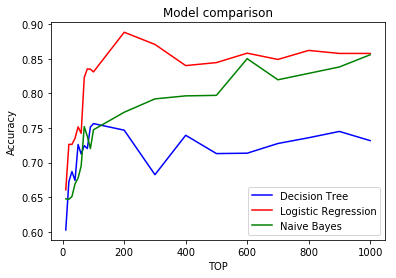

In [2]:
import pandas as pd
import nltk
import numpy as np
import re
from nltk import PorterStemmer
from nltk.corpus import stopwords
import string
from wordcloud import wordcloud

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest, chi2

letters = set(string.letters)
digits = set(string.digits)

stop_words = set(stopwords.words("english"))

# Read csv file containing speeches as txt and there classification (obama, clinton, bush)
def readData(path):
    # data["speech"]
    # data["class"]
    print "Reading data..."
    data = pd.read_csv(path, header=0)

    # Clean punctuation
    data.speech = data.speech.apply(lambda x: re.sub("[^a-zA-Z0-9]", " ", x).lower())

    # Tokenize
    data.tokens = data.speech.apply(lambda x: nltk.word_tokenize(x))

    # stem
    stemmer = PorterStemmer()
    data.stemmed = data.tokens.apply(lambda x: np.array([stemmer.stem(word) for word in x]))

    # remove stop words

    data.stop_words_free = data.stemmed.apply(lambda x: np.array([w for w in x if w not in stop_words]))
    
    print "Creating a bag of words..."
    
    # Create bag of words
    vocab = set()
    # Count document frequency
    df_dict = dict()

    data.dict = dict()

    for index, tokens in enumerate(data.stop_words_free):
        data.dict[index] = dict()
        for token in tokens:

            vocab.add(token)

            if token in data.dict[index]:
                data.dict[index][token] += 1
            else:
                data.dict[index][token] = 1

            # DF
            if token in df_dict:
                if index not in df_dict[token]:
                    df_dict[token].add(index)
            else:
                df_dict[token] = set()
                df_dict[token].add(index)

    features = sorted(vocab)
    features.append("classs")

    columns = []
    count = 0
    for feature in features[:-1]:
        col = []
        for key, value in data.dict.iteritems():
            if feature in value:
                col.append(value[feature])
            else:
                col.append(0)
        columns.append(col)
        count += 1

    columns.append(data["classs"])
    columns = np.array(columns)

    pd_data = pd.DataFrame(np.column_stack(columns), columns=features)

    pres = {"obama": 0, "bush": 1, "clinton": 2}
    pd_data["class_"] = pd_data["classs"].apply(lambda x: pres[x] if x in pres else 3)

    predictors = np.asarray(features)[0:-1]
    target = "class_"
    
    print "Done"
    print "Prepering data for classification..."
    
    x = pd_data[predictors]
    y = pd_data[target]

    # Select features
    new_data = feature_selection(x, y)
    
    print "Initiating decision tree classifier"
    # Decision Tree
    clf = DecisionTreeClassifier(random_state=0)
    dt_scores = score_model(new_data, clf, y)

    print "Initiating logistic regression classifier"
    # Logistic Regression
    lr = LogisticRegression()
    lr_scores = score_model(new_data, lr, y)

    print "Initiating naive bayes classifier"
    # Naive Bayes
    nb = GaussianNB()
    nb_scores = score_model(new_data, nb, y)
    
    print "Plotting results"
    plt.figure()
    plt.plot(top_array, [score[1] for score in dt_scores], "b", label="Decision Tree")
    plt.plot(top_array, [score[1] for score in lr_scores], "r", label="Logistic Regression")
    plt.plot(top_array, [score[1] for score in nb_scores], "g", label="Naive Bayes")

    plt.xlabel("TOP")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.title("Model comparison")

    plt.show()


top_array = [10, 20, 30, 40, 50, 60, 70, 80 ,90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


def feature_selection(x, y):

    data_tops = []
    for num in top_array:
        data_tops.append(SelectKBest(chi2, k=num).fit_transform(x, y))

    # returns array containing data with different number of features selected
    return data_tops


def score_model(data, model, y):

    score_list = []
    for x in data:

        score = cross_val_score(model, x, y, cv=10)
        score_list.append((x.shape[1], score.mean()))

    return score_list


path = "PoliticalSpeeches\data.csv"
readData(path)

The graph above provides information about the Accuracy of each model at a different number of features provuded. As we can see we achieved around 90% accuracy using the Logistic regression classifier and a 10-Fold cross-validation at around 200 features.

# Part 3 - Text generation using Neural Network

In this part of the project we will generate new sequences using the speech data we have collected and a simple sequential model. For each president we will create new speech collection by training the model on 70% of the sentences for each president and using the trained model to generate new speech from the remaining 30%. From each speech in the 30%, we will generate a seperate sequence by passing word by word from the speech to the model and recieving back a word that the model decided that has the highest chance to come after that word. As a result we will generate a new speech collection which will be 30% the size of the data collection. An example for the president Bush new speech collection generation:

In [ ]:
from keras.preprocessing.text import text_to_word_sequence
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
import csv
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.embeddings import Embedding

path = "PoliticalSpeeches\data_bush.csv"

# Reading the data
data = pd.read_csv(path, header=0)

vocabulary_size = 600

# Definition of tokens
unknown_token = "UNKNOWNTOKEN"

sentence_start_token = "SENTENCESTART"
sentence_end_token = "SENTENCEEND"

line_break = "NEWLINE"
separator = "SEPARATOR"

indice = int(data.shape[0] * 0.7)
text = ". ".join(data["speech"][0:])
text_gen_sentences = data["speech"][indice:]


# Replace tokens like punctuations with predefined symbols
def text_prep(text):
    text1 = text.replace('\n', ' ' + line_break + ' ')
    text1 = text1.replace('--', ' ' + separator + ' ')
    text1 = text1.replace('.', ' ' + sentence_end_token + ' ' + sentence_start_token + ' ')
    return text1

text1 = text_prep(text)

# split text into a sequence of words
text2 = text_to_word_sequence(text1, lower=False, split=" ")

# Tokenize
token = Tokenizer(num_words=600,char_level=False)
token.fit_on_texts(text2)

text_mtx = token.texts_to_matrix(text2, mode='binary')

# print text_mtx.shape

input_ = text_mtx[:-1]
output_ = text_mtx[1:]

# print input_.shape, output_.shape

# Create model and add layers
model = Sequential()
model.add(Embedding(input_dim=input_.shape[1], output_dim=42, input_length=input_.shape[1]))
model.add(Flatten())
model.add(Dense(output_.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

model.fit(input_, y=output_, batch_size=300, nb_epoch=10, verbose=1, validation_split=0.2)

# The function receives text, token and the trained model, and return the word predicted by the model that should
# come after that token
def get_next(text, token, model, fullmtx, fullText):
    tmp = text_to_word_sequence(text, lower=False, split=" ")
    tmp = token.texts_to_matrix(tmp, mode='binary')
    p = model.predict(tmp)
    try:
        bestMatch = np.min(np.argmax(p))
        next_idx = np.min(np.where(fullmtx[:,bestMatch]>0))
    except:
        return ""
    return fullText[next_idx]

sent_for_generation = []
new_sentences = []
i = 0

for text_gen in text_gen_sentences:
    sequence = []
    clear_text = text_prep(text_gen)
    word = clear_text.split()[0]
    for word in clear_text.split():
        sequence.append(get_next(word, token, model, text_mtx, text2))
    new_sentences.append([i, " ".join(sequence)])
    i += 1


# print sequence
with open("PoliticalSpeeches\new_sentences_bush.csv", 'wb') as out_file:
    csv_writer = csv.writer(out_file)
    # csv_writer.writerow([0, " ".join(sequence)])
    for sentence in new_sentences:
        csv_writer.writerow(sentence)

As a result, we receive a new CSV file with new sequences created using the trained model, which will be used as the test data for Part 4, to see how well the model from the previous part can predict which new speech belongs to which president.

The results can be seen in the 3 new CSV files : new_sentences_bush.csv, new_sentences_clinton.csv, new_sentences_obama.csv located in the PoliticalSpeeches folder.
Lets take a look inside one of the files:

> States of the SENTENCEEND want SENTENCEEND SENTENCEEND the SENTENCEEND well SENTENCEEND well the SENTENCEEND the United SENTENCEEND the SENTENCEEND is SENTENCEEND SENTENCEEND SENTENCEEND well new country SENTENCEEND is SENTENCEEND the SENTENCEEND to SENTENCEEND United SENTENCEEND SENTENCEEND SENTENCESTART the a new SENTENCEEND SENTENCEEND is SENTENCEEND country SENTENCEEND country and the United SENTENCEEND is country country SENTENCEEND a SENTENCEEND the SENTENCEEND own SENTENCEEND the own SENTENCEEND SENTENCEEND SENTENCEEND SENTENCEEND the SENTENCEEND the SENTENCEEND the is SENTENCEEND SENTENCEEND own SENTENCEEND SENTENCESTART the country SENTENCEEND be be the country SENTENCEEND country SENTENCEEND the country to SENTENCEEND United SENTENCEEND the end.

As we can see from a part taken from a new speech, most of the sentence is constructed by the panctuation tokens and common words like "the", "country" and "be" apper a lot. Most of the sentences don't make much sense but removing punctuation and stop words will result in a sentence containing only nouns and verbs without any seperators or connectors between the words which will also result in sentence with little meaning. Increasing the number of epochs or adding additional layers to the network might improve the sentence quality, but those steps require more computer resources that our computers couldn't handle. A more sophisticated model like RNN could also to the trick, but as we tried to run it we ran out of memory to quickly and couldn't achieve anything.

For the next part will take the new sentnces and see if the machine learning algorthims from Part2 can identify from which politicial the sentence was creted from.

# Part 4 - Classification of the new sequences

Using the classifiers from Part2 we will try and predict which sentence was generated from which president speeches.

At first, we read the new sequences created in the previous Part and perform basic preprocessing to clean the data. The steps we do are: Reading the data -> replacing punctuation tokens -> Tokenizing -> Stemming -> Removing stop words.

In [ ]:
import nltk
import pandas as pd
import csvwords
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split


plt.interactive(False)
new_sequence_path_bush = "PoliticalSpeeches\new_sentences_bush.csv"
new_sequence_path_obama = "PoliticalSpeeches\new_sentences_obama.csv"
new_sequence_path_clinton = "PoliticalSpeeches\new_sentences_clinton.csv"

path = "PoliticalSpeeches\data.csv"

unknown_token = "UNKNOWNTOKEN"

sentence_start_token = "SENTENCESTART"
sentence_end_token = "SENTENCEEND"

line_break = "NEWLINE"
separator = "SEPARATOR"

stop_words = set(stopwords.words("english"))

top_array = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

bush_num = 0
clinton_num = 0
obama_num = 0


# Read the sequences
sentences = []
with open(new_sequence_path_bush, 'rb') as in_file:
    csv_reader = csv.reader(in_file)
    for row in csv_reader:
        sentences.append(row)
        bush_num += 1

with open(new_sequence_path_clinton, 'rb') as in_file:
    csv_reader = csv.reader(in_file)
    for row in csv_reader:
        sentences.append(row)
        clinton_num += 1

with open(new_sequence_path_obama, 'rb') as in_file:
    csv_reader = csv.reader(in_file)
    for row in csv_reader:
        sentences.append(row)
        obama_num += 1

# Remove "punctuation" added in the previous part
for ind, sent in enumerate(sentences):
    sentences[ind][1] = sent[1].replace(unknown_token, "").replace(sentence_start_token, "") \
    .replace(sentence_end_token, "").replace(line_break, "").replace(separator, "")

stemmer = PorterStemmer()

new_speech_data = []
for sent in sentences:
    tmp_sent = sent[1]

    # Tokenize
    tokens = tmp_sent.split()

    # Stem
    stemmed = np.array([stemmer.stem(word) for word in tokens])

    # Remove stop words
    stopword_free = [w for w in stemmed if w not in stop_words]

    new_speech_data.append(stopword_free)

The next step is to prepare the data for the new sequences to match the data from Part2 and create a bag of words.

In [ ]:
# Prepare data
print "Reading data..."
data = pd.read_csv(path, header=0)

print "Preprocessing..."
# Clean punctuation
data.speech = data.speech.apply(lambda x: re.sub("[^a-zA-Z0-9]", " ", x).lower())

# Tokenize
data.tokens = data.speech.apply(lambda x: nltk.word_tokenize(x))

# stem
stemmer = PorterStemmer()
data.stemmed = data.tokens.apply(lambda x: np.array([stemmer.stem(word) for word in x]))

# remove stop words

data.stop_words_free = data.stemmed.apply(lambda x: np.array([w for w in x if w not in stop_words]))

print "Creating a bag of words"
# Create bag of words
vocab = set()
# Count document frequency
df_dict = dict()

data.dict = dict()

# Create bag of words
for index, tokens in enumerate(data.stop_words_free):
    data.dict[index] = dict()
    for token in tokens:

        vocab.add(token)

        if token in data.dict[index]:
            data.dict[index][token] += 1
        else:
            data.dict[index][token] = 1

        # DF
        if token in df_dict:
            if index not in df_dict[token]:
                df_dict[token].add(index)
        else:
            df_dict[token] = set()
            df_dict[token].add(index)

# Sort features
features = sorted(vocab)

# "Class" exist as a feature so add other target name
features.append("classs")

columns = []
count = 0

# Prepare the bag of words
for feature in features[:-1]:
    col = []
    for key, value in data.dict.iteritems():
        if feature in value:
            col.append(value[feature])
        else:
            col.append(0)

    for key, value in new_speech_dict.iteritems():
        if feature in value:
            col.append(value[feature])
        else:
            col.append(0)

    columns.append(col)
    count += 1

new_speech_targets = ("bush " * bush_num + "clinton " * clinton_num + "obama " * obama_num).split()


columns.append(data["classs"])
new_speech_series = zip(new_speech_targets, [i for i in range(len(columns[-1]),
                                                              len(columns[-1]) + len(new_speech_targets))])

for value in new_speech_series:
    columns[-1].set_value(value[1], value[0])

columns = np.array(columns)

pd_data = pd.DataFrame(np.column_stack(columns), columns=features)

# Categorize target
pres = {"obama": 0, "bush": 1, "clinton": 2}
pd_data["class_"] = pd_data["classs"].apply(lambda x: pres[x] if x in pres else 3)

predictors = np.asarray(features)[0:-1]
target = "class_"

print "Prepring data for classification"
x = pd_data[predictors]
y = pd_data[target]

def feature_selection(x, y):

    data_tops = []
    for num in top_array:
        data_tops.append(SelectKBest(chi2, k=num).fit_transform(x, y))

    # returns array containing data with different number of features selected
    return data_tops

# Select features
new_data = feature_selection(x, y)[8]
# print len(full_new_data)

#for new_data in full_new_data:

class_names = ["Bush", "Clinton", "Obama"]

We have tested out the number of features that gave us to the best results for each classifier. For the Logistic regression classifier 80 features brought the best result.

In [ ]:
x_train = new_data[0:len(new_data) - len(sentences)]
x_test = new_data[len(new_data) - len(sentences):]

y_train = y[0:len(y) - len(sentences)]
y_test = y[len(y) - len(sentences):]

print len(x_train), len(x_test), len(y_train), len(y_test)

print "Initiating Logistic Regression"
# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train, y_train)

prediction = lr.predict(x_test)

# print prediction
# print type(y_test)

print accuracy_score(y_test, prediction) * 100, "%"
print confusion_matrix(y_test, prediction)

The results achieved were around 60% accuracy, we can see the distribution in the following confusion matrix:
![Confusion Matrix1](img/cm_lr.JPG)

![Confusion Matrix](img/cmlr.jpeg)

In [ ]:
print "Initiating Decision Tree"
clf = DecisionTreeClassifier(random_state=0)

clf.fit(x_train, y_train)

prediction = clf.predict(x_test)

print accuracy_score(y_test, prediction) * 100, "%"
print confusion_matrix(y_test, prediction)

The the Decision tree classifier achieved 63% accuracy using 70 features.
![Confusion Matrix1](img/cm_dt.JPG)
![Confusion Matrix](img/cmdt.jpeg)

In [ ]:
print "Initiating NB"
nb = GaussianNB()

nb.fit(x_train, y_train)

prediction = nb.predict(x_test)

print accuracy_score(y_test, prediction) * 100, "%"
print confusion_matrix(y_test, prediction)

The NB classifier achieved the highest score between the tree classifiers with 75% accuracy using 20 features.
![Confusion Matrix1](img/cm_nb.JPG)
![Confusion Matrix](img/cmnb.jpeg)

As we can see, the nb model has achieved a reasonable score using small amount of features. In our opinion the reason is that most speeches contain mostly the same words and that just a small amount of words depend on the president that gave the speech, or the time in history that the president was in the position. In the DT and LR model, we can see that the models have a problem to destinguish between Obama's and Clinton's speeches, which strengthen our theory.

Lets take a look at the popular word from the speech collection of each president:
![word_cloud](img/word_cloud.JPG)

We can see that there are a lot of words in common, for exmaple the word "work", but if we look seperatly we can see that Bush is talking a lot about Iraq and war, while Clinton's and Obama's speeches have a lot of reference to the word health.

# Conclusion

In conclusion, we can see that a simple Neural Network model can create a well enough constructed new speech from training on a speech collection, that classification models can predict the president which the speech relates to, even though it doesn't make sense to us.
    